In [1]:
import pandas as pd
import pyomo.environ as pyo

In [3]:
DistMat = pd.read_excel("distance_matrix.xlsx", header = 0, index_col = 0)

In [4]:
DistMat # we dont want to go from 1 to 1, so the distance between 1 and 1 is set to a very large number

,1,2,3,4,5,6,7,8,9,10
1,1000000.000000,22.913435,81.613048,99.766739,19.811102,66.093300,43.227981,8.475453,11.542688,19.352689
2,22.913435,1000000.000000,91.004413,75.800872,54.425097,11.432559,88.017123,63.032838,20.202093,63.047480
3,81.613048,91.004413,1000000.000000,58.813041,16.181759,53.585564,95.871757,19.928651,18.251319,91.029236
4,99.766739,75.800872,58.813041,1000000.000000,40.329785,33.635534,83.436119,89.681160,74.708686,11.153196
5,19.811102,54.425097,16.181759,40.329785,1000000.000000,18.682737,37.166945,71.946668,20.055402,93.568656
6,66.093300,11.432559,53.585564,33.635534,18.682737,1000000.000000,91.921080,55.411004,7.124644,83.884388
7,43.227981,88.017123,95.871757,83.436119,37.166945,91.921080,1000000.000000,43.336050,77.862595,85.696612
8,8.475453,63.032838,19.928651,89.681160,71.946668,55.411004,43.336050,1000000.000000,49.799675,7.867604
9,11.542688,20.202093,18.251319,74.708686,20.055402,7.124644,77.862595,49.799675,1000000.000000,49.406673
10,19.352689,63.047480,91.029236,11.153196,93.568656,83.884388,85.696612,7.867604,49.406673,1000000.000000


In [5]:
C = list(DistMat.columns)
R = list(DistMat.index)

In [6]:
Dist = {(r, c):DistMat.at[r,c] for r in R for c in C}

## Explanation

We want to minimize the tour distance, therefore the objective function is equal to the Dist[r,c]*x[r,c].

first constraint ensures that there is an output from every row to one of the columns.

the second one ensures that from every row there is an input from one of the columns.

the third row ensures that a subtour will not be generated, in other words when we go to node c from node r, we cannot 
go back from r to c again. This is based on Miller–Tucker–Zemlin formulation.

source: https://en.wikipedia.org/wiki/Travelling_salesman_problem

## Decision Variable

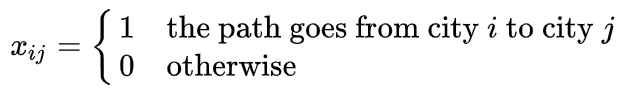

## Objective Function

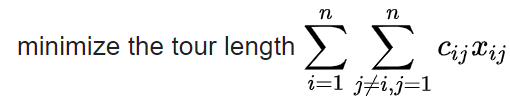

## Input-Output Constraints

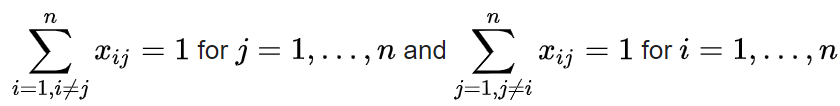

## Miller–Tucker–Zemlin Constraint

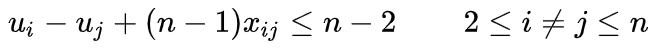

In [11]:
def TSP_model(R, C, Dist):
    """
        R   : set of cities (locations)
        C   : set of cities (locations)
        Dist: transportation distance
    """
    
    model = pyo.ConcreteModel(name="(TSP)")
    
    model.x = pyo.Var(R, C, within=pyo.Binary)
    model.u = pyo.Var(R, within=pyo.NonNegativeIntegers)

    def obj_rule(model):
        return sum(Dist[r,c]*model.x[r,c] for r in R for c in C)
    model.obj = pyo.Objective(rule=obj_rule)

    def row_rule(model, r):
        return sum(model.x[r,c] for c in C) == 1
    model.row = pyo.Constraint(R, rule=row_rule)
    
    def col_rule(model, c):
        return sum(model.x[r,c] for r in R) == 1
    model.col = pyo.Constraint(C, rule=col_rule)
    
    def visit_rule(model,r,c):
        if r != c:
            return model.u[r] - model.u[c] + len(R)*model.x[r,c] <= len(R) - 1
        else:
            return  pyo.Constraint.Skip #model.u[r] - model.u[r] == 0 
    model.visit = pyo.Constraint(list(set(R)-{1}),list(set(C)-{1}), rule=visit_rule)
    
    return model

In [12]:
model = TSP_model(R, C, Dist)

In [13]:
solver = pyo.SolverFactory("glpk")
res = solver.solve(model)

print(pyo.check_optimal_termination(res))

True


In [14]:
model.display()

Model '(TSP)'

  Variables:
    x : Size=100, Index=x_index
        Key      : Lower : Value : Upper : Fixed : Stale : Domain
          (1, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 2) :     0 :   0.0 :     1 : False : False : Binary
          (1, 3) :     0 :   0.0 :     1 : False : False : Binary
          (1, 4) :     0 :   0.0 :     1 : False : False : Binary
          (1, 5) :     0 :   0.0 :     1 : False : False : Binary
          (1, 6) :     0 :   0.0 :     1 : False : False : Binary
          (1, 7) :     0 :   1.0 :     1 : False : False : Binary
          (1, 8) :     0 :   0.0 :     1 : False : False : Binary
          (1, 9) :     0 :   0.0 :     1 : False : False : Binary
         (1, 10) :     0 :   0.0 :     1 : False : False : Binary
          (2, 1) :     0 :   0.0 :     1 : False : False : Binary
          (2, 2) :     0 :   0.0 :     1 : False : False : Binary
          (2, 3) :     0 :   0.0 :     1 : False : False : Binary
          (2, 4)

In [26]:
for r in R:
    for c in C:
        if pyo.value(model.x[r,c]) == 1:
            print(f"{r} => {c}")

1 => 7
2 => 6
3 => 9
4 => 10
5 => 3
6 => 4
7 => 5
8 => 1
9 => 2
10 => 8
